In [1]:
import uproot, ROOT, glob, os, random
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from sklearn.metrics import roc_curve, roc_auc_score, auc
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier
from array import array
import ctypes
import h5py


Welcome to JupyROOT 6.28/04


In [ ]:
# def getXS(dsid):
#     xs_file = "/cvmfs/atlas.cern.ch/repo/sw/database/GroupData/dev/PMGTools/PMGxsecDB_mc16.txt"
#     try:
#         with open(xs_file, "r") as f:
#             for line in f:
#                 columns = line.split()
#                 if columns[0] == str(dsid):
#                     return float(columns[2])*float(columns[3])*float(columns[4])
#         print( "Couldn't find cross section for dsid", dsid, "so setting to 1.")
#     except IOError:
#         print("Cross section file not accessible on cvmfs.", dsid, " XS setting to 1.")
#     return 1

# def flattened_pt_weighted(data, bins, weight):
#     weights = np.zeros(len(data))
#     pt_hist, bin_edges = np.histogram(data, bins=bins, weights=weight)
#     for i in range(len(pt_hist)):
#         if pt_hist[i] == 0:
#             weights = np.where((data >= bin_edges[i]) & (data < bin_edges[i+1]), 1, weights)
#         else:
#             weights = np.where((data >= bin_edges[i]) & (data < bin_edges[i+1]), 1/pt_hist[i], weights)

#     return weights

# path = '/global/homes/a/agarabag/pscratch/ditdau_samples/'s

# dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
#                 "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
#                 "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
#                 "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
#                 "d0_leadtrack_lead", "d0_leadtrack_subl",
#                 "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
#                 "event_weight", "bdt_score"]

# index = 0
# ditau = h5py.File(path+f"ditau_flattened_{index}.h5")
# ditau.keys()

In [ ]:
# # H5 -> Panda DataFrame
# # Cross Section
# bkg_xs = [364701, 364702, 364703, 364704, 364705, 364706,
#       364707, 364708, 364709, 364710, 364711, 364712]
# graviton_xs = [425108, 425100, 425101, 425102, 425103, 425104, 425105, 425106, 425107]
# gamma_xs = [425200]

# # File Location
# bkg_filelist = []
# for index in tqdm(range(13)):
#     bkg_filelist.append('jz_w_newbdt/'+f"ditau_flattened_{index}.h5")
     
# graviton_filelist = [
#     "signal_w_newbdt/graviton_flattened_M1000.h5",
#     "signal_w_newbdt/graviton_flattened_M1500.h5",
#     "signal_w_newbdt/graviton_flattened_M1750.h5",
#     "signal_w_newbdt/graviton_flattened_M2000.h5",
#     "signal_w_newbdt/graviton_flattened_M2250.h5",
#     "signal_w_newbdt/graviton_flattened_M2500.h5",
#     "signal_w_newbdt/graviton_flattened_M3000.h5",
#     "signal_w_newbdt/graviton_flattened_M4000.h5",
#     "signal_w_newbdt/graviton_flattened_M5000.h5"]

# gamma_filelist = ["gamma_flattened_0.h5"]

# new_gamma_file = ["signal_w_newbdt/gamma_flattened_0.h5"]

# # Selection Cut
# def bkg_cut(df_chunk):
#     return ((df_chunk['n_subjets'] >=2) &
#            (df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6) &
#             (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3))))

# def signal_cut(df_chunk):
#     return ((df_chunk['IsTruthHadronic']==1) & (df_chunk['n_subjets'] >=2) &
#               (df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6) &
#                 (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3))))

# # Define the chunk size
# chunk_size = 10000000  # Adjust this size to suit your system's memory

# # Define pT bins for pt weight
# pt_bins = np.linspace(200000, 1000000, 41)

# def h52panda(filelist, xs, cut):
#     combined = pd.DataFrame()
    
#     for index in range(len(filelist)):
#         file_path = path + filelist[index]
    
#         # Process the file in chunks
#         with h5py.File(file_path, 'r') as h5_file:
#             # Determine the total length of the datasets
#             total_length = h5_file[dataset_keys[0]].shape[0]
#             print(f'{filelist[index]}: {total_length}')

#             # Read and process each chunk
#             for chunk_start in range(0, total_length, chunk_size):
#                 chunk_end = chunk_start + chunk_size

#                 # Use slicing to read a chunk from each dataset in the HDF5 file
#                 data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}

#                 # Convert the dictionary to a pandas DataFrame
#                 df_chunk = pd.DataFrame(data)

#                 # Apply Cut
#                 filtered_chunk = df_chunk[cut(df_chunk)]
#                 filtered_chunk = filtered_chunk.copy()
#                 filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index])

#                 combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
#     combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])

#     return combined


In [2]:
# path = "/global/u2/a/agarabag/pscratch/ditdau_samples/"
# combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
# combined_signal = pd.read_csv(path+'combined_signal_inc.csv')
# # combined_signal = pd.read_csv(path+'vhtautau_ntuple_inc.csv')
# df = pd.concat([combined_bkg, combined_signal])
# df

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,n_tracks_subl,n_subjets,event_weight,bdt_score,bdt_score_new,average_mu,eta,pT_weight,label,weight
0,36079784,289045.94,0,0.894528,0.246616,0.026755,0.729273,0.014855,0.055002,0.140860,...,1,2,9.602898e+01,0.394018,0.001220,50.500000,-1.064851,0.007321,0,7.030488e-01
1,27319135,202522.75,0,0.845665,0.814488,0.074589,0.621756,0.023605,0.131976,0.073351,...,1,2,9.602898e+01,0.579747,0.069451,43.500000,0.806814,0.004301,0,4.130602e-01
2,31168046,228276.44,0,0.931244,0.580674,0.048891,0.748935,0.018526,0.170364,0.115179,...,1,2,9.602898e+01,0.566327,0.053727,61.500004,0.584187,0.004747,0,4.558659e-01
3,35893734,248336.08,0,0.680812,0.653458,0.044117,0.710676,0.025507,0.184587,0.120126,...,1,2,9.602898e+01,0.419675,0.004770,46.500004,2.402946,0.005332,0,5.120142e-01
4,28661182,207010.69,0,0.883104,0.701180,0.167451,0.676483,0.022352,0.041758,0.114734,...,3,3,1.601067e-01,0.437940,0.165671,41.499996,0.418528,0.004301,0,6.886847e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293151,41863732,402376.50,1,0.938707,0.819963,0.128798,0.858344,0.002552,0.010547,0.011293,...,1,2,2.144577e-10,0.800688,0.995590,27.500000,-1.050984,1824.306013,1,3.912365e-07
293152,41875682,257150.30,1,0.937242,0.856229,0.368471,0.830305,0.000000,0.023579,0.013075,...,1,2,2.144577e-10,0.750652,0.992877,34.500000,2.017023,3640.309120,1,7.806923e-07
293153,41933178,483415.30,1,0.962991,0.943157,0.263034,0.892043,0.000000,0.012886,0.021818,...,3,2,2.144577e-10,0.763553,0.995572,30.500000,0.047959,4056.854290,1,8.700236e-07
293154,41978643,265805.56,1,0.884850,0.891054,0.140300,0.820904,0.022341,0.008732,0.026567,...,1,2,2.144577e-10,0.701484,0.970486,34.500000,2.286975,2174.839596,1,4.664111e-07


In [2]:
path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"
combined_bkg = pd.read_csv(path+'combined_jz_ntuple_inc.csv')
combined_signal = pd.read_csv(path+'vhtautau_ntuple_inc.csv')
# combined_signal = pd.read_csv('/global/u2/a/agarabag/pscratch/ditdau_samples/combined_signal_inc.csv')
df = pd.concat([combined_bkg, combined_signal])
df

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,event_weight,bdt_score,bdt_score_new,average_mu,eta,lead_subjet_pt,sublead_subjet_pt,pT_weight,label,weight
0,10085719,300596.03,0,0.841778,0.098343,0.049672,0.870744,0.022996,0.183503,0.188156,...,4.258413e+06,0.383750,0.003208,28.5,-0.293797,283448.44,17147.588,2.347177e-07,0,9.995250e-01
1,12932274,216630.72,0,0.794682,0.629580,0.237235,0.720417,0.022866,0.023344,0.103682,...,4.452275e+04,0.508101,0.056426,52.5,-1.207046,145293.81,71336.900,2.194466e-05,0,9.770365e-01
2,17175243,273065.28,0,0.777353,0.152971,0.034437,0.828344,0.093140,0.020684,0.129106,...,1.474182e+05,0.474229,0.006495,52.5,-1.601396,261713.06,11352.231,6.713848e-06,0,9.897431e-01
3,3612531,222817.73,0,0.822131,0.329967,0.044670,0.718734,0.031373,0.062170,0.131811,...,3.664807e+04,0.387727,0.002754,59.5,1.255504,208969.48,13848.256,2.635199e-05,0,9.657497e-01
4,2712131,345894.03,0,0.899058,0.197741,0.053103,0.884523,0.004823,0.186105,0.141177,...,6.951111e+03,0.525784,0.010974,55.5,-0.167395,325128.03,20766.006,1.389082e-04,0,9.655662e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4842177,13197187,431976.44,1,0.951974,0.873579,0.185070,0.846039,0.011745,0.009147,0.011547,...,3.150254e-12,0.769205,0.986443,65.5,1.014485,337482.25,94494.195,1.781179e+05,1,5.611166e-07
4842178,13197197,506210.80,1,0.922233,0.691846,0.057907,0.892159,0.003076,0.018185,0.057121,...,2.068809e-12,0.655302,0.757044,66.5,-0.262314,473354.38,32856.420,4.506018e+05,1,9.322092e-07
4842179,13197190,839142.60,1,0.871092,0.921659,0.264379,0.937399,0.000000,0.010120,0.011831,...,7.508517e-13,0.785865,0.987781,66.5,0.752680,602475.40,236667.230,1.035244e+07,1,7.773145e-06
4842180,13197200,341988.47,1,0.785581,0.929359,0.413273,0.837190,0.014225,0.021818,0.017692,...,2.391564e-10,0.759621,0.993915,67.5,1.373492,173168.30,168820.170,6.556927e+04,1,1.568131e-05


In [3]:
# count how many envts with lable 0 and 1
print(df['label'].value_counts())

label
1    4842182
0    1147050
Name: count, dtype: int64


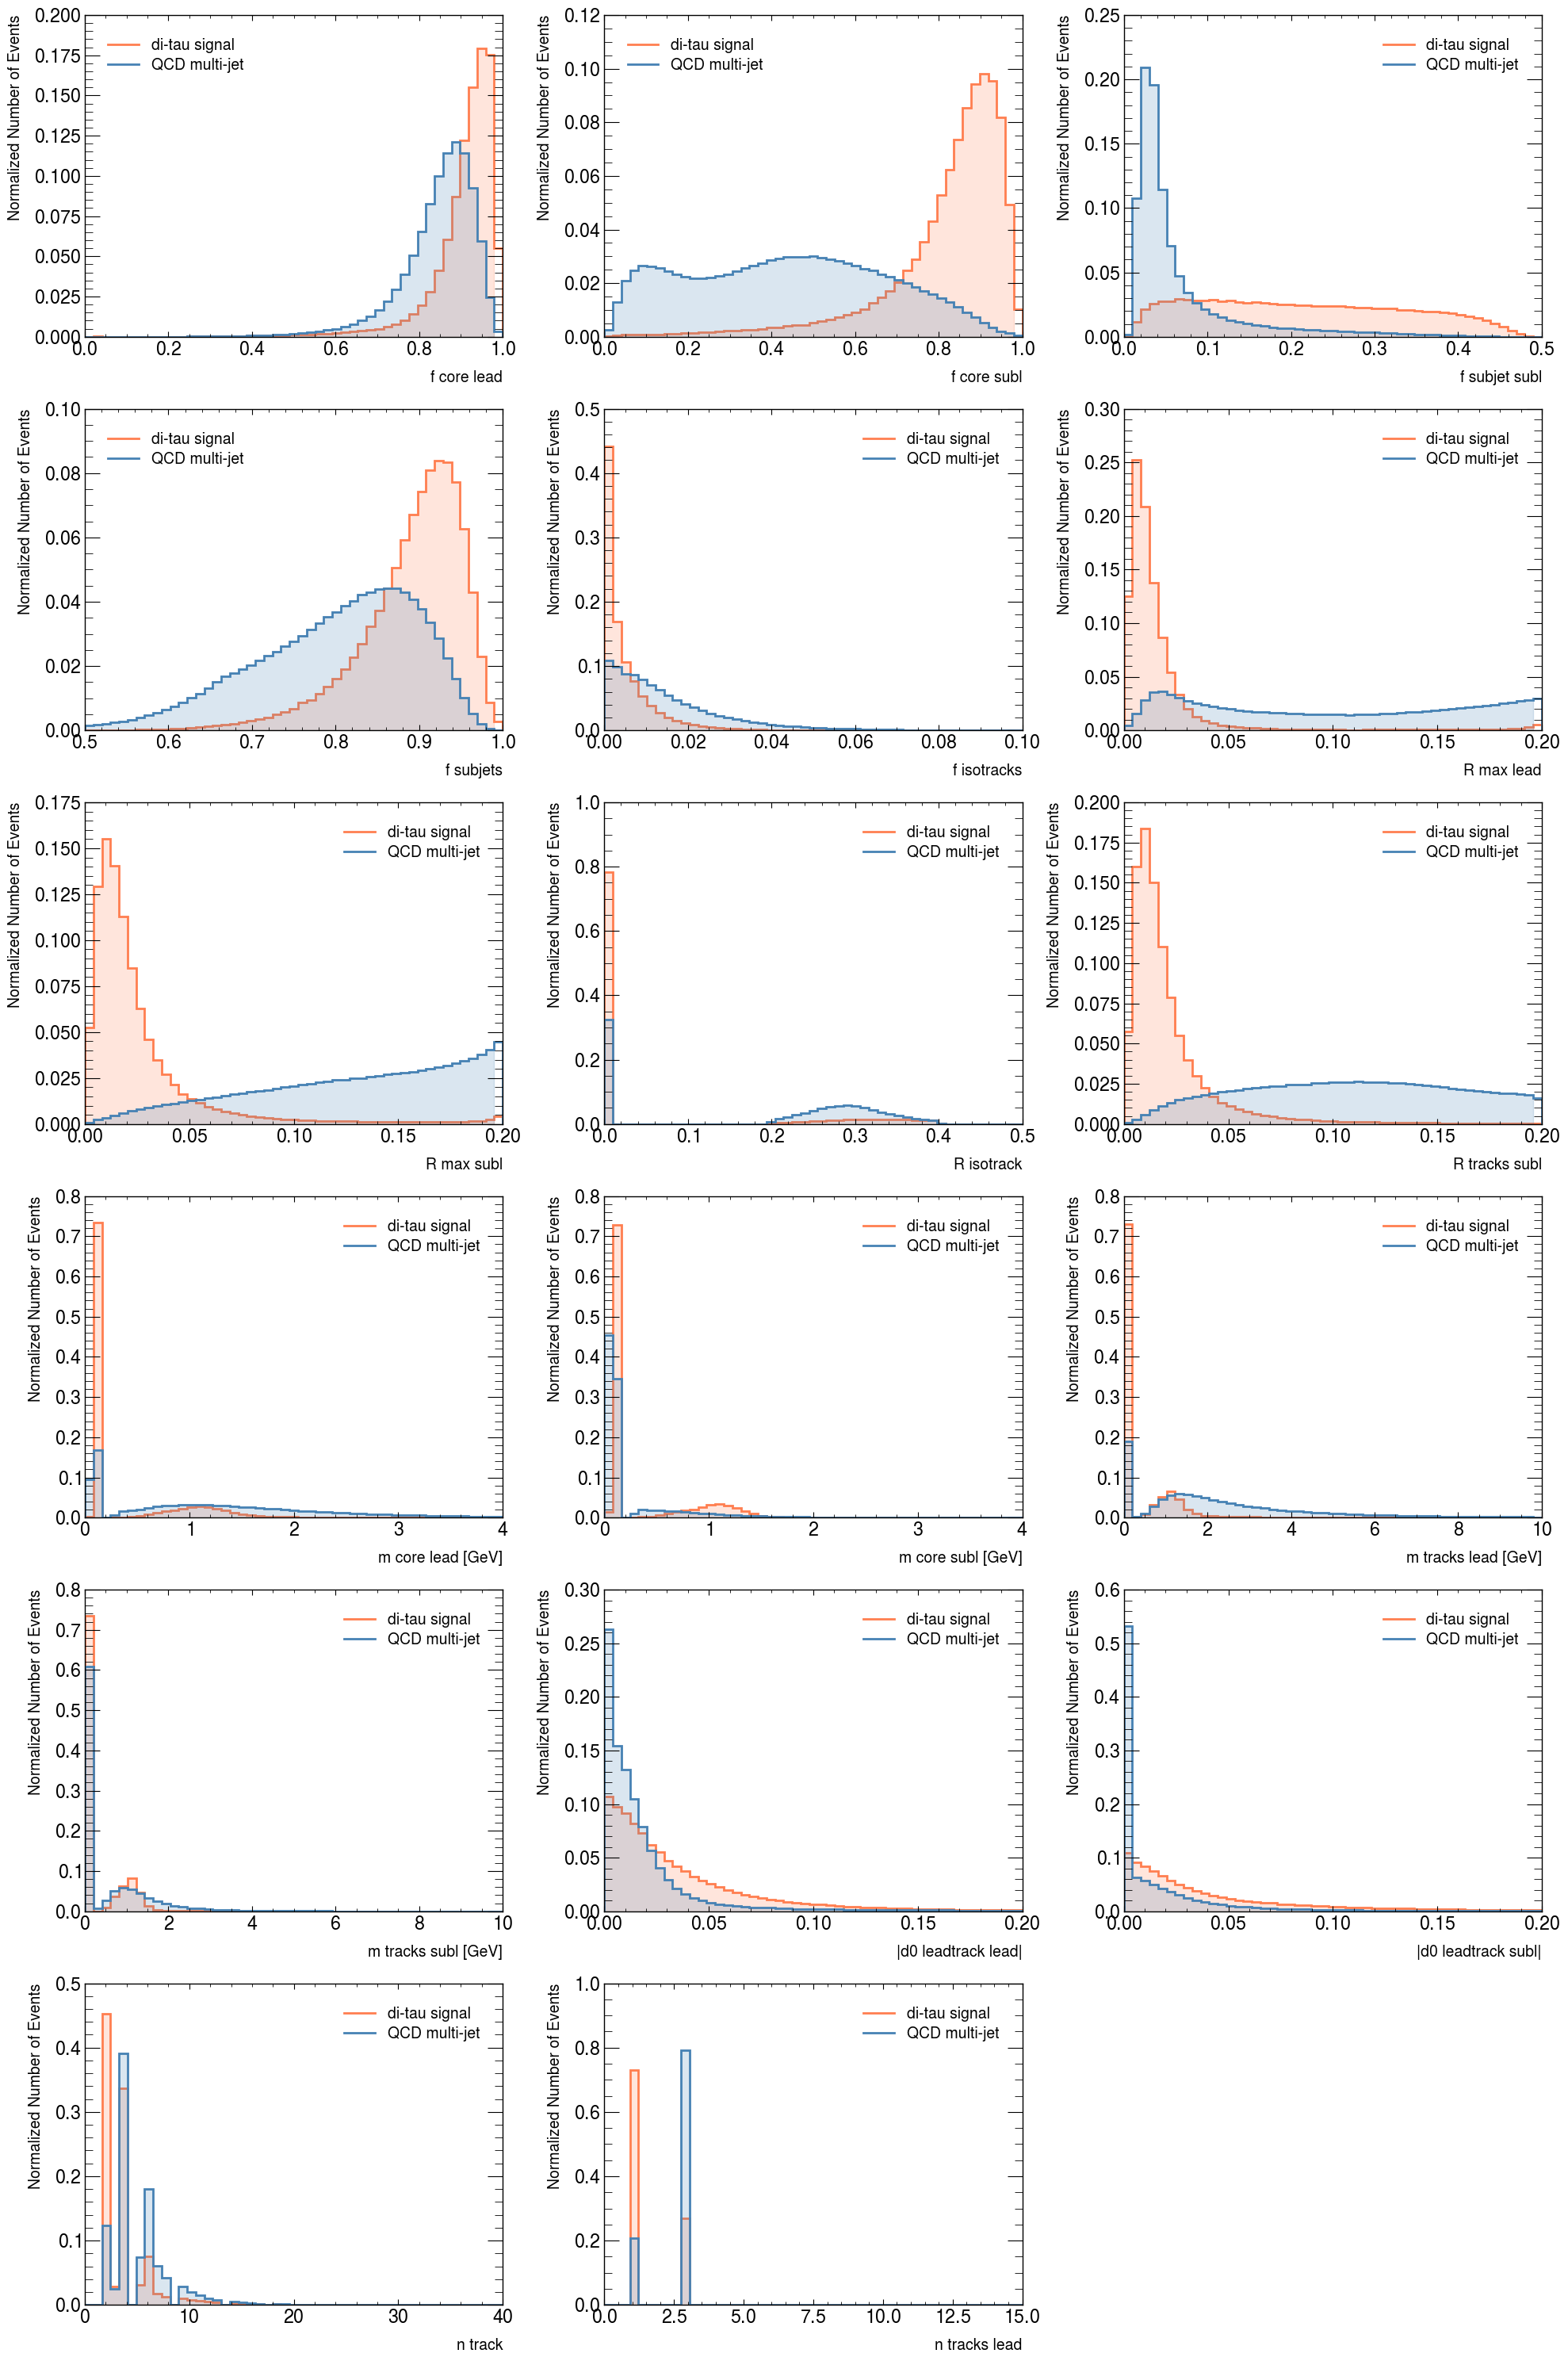

In [3]:
import mplhep as hep

# Set the style to ATLAS
plt.style.use(hep.style.ATLAS)

# Define the variables to plot with their specific ranges
training_vars = {
    "f_core_lead": (0, 1, "f core lead"),
    "f_core_subl": (0, 1, "f core subl"),
    "f_subjet_subl": (0, 0.5, "f subjet subl"),
    "f_subjets": (0.5, 1, "f subjets"),
    "f_isotracks": (0, 0.1, "f isotracks"),
    "R_max_lead": (0, 0.2, "R max lead"),
    "R_max_subl": (0, 0.2, "R max subl"),
    "R_isotrack": (0, 0.5, "R isotrack"),  # log scale
    "R_tracks_subl": (0, 0.2, "R tracks subl"),
    "m_core_lead": (0, 4, "m core lead [GeV]"),
    "m_core_subl": (0, 4, "m core subl [GeV]"),
    "m_tracks_lead": (0, 10, "m tracks lead [GeV]"),
    "m_tracks_subl": (0, 10, "m tracks subl [GeV]"),
    "d0_leadtrack_lead": (0, 0.2, "|d0 leadtrack lead|"),
    "d0_leadtrack_subl": (0, 0.2, "|d0 leadtrack subl|"),
    "n_track": (0, 40, "n track"),
    "n_tracks_lead": (0, 15, "n tracks lead")
}

# Create a figure with subplots
n_cols = 3
n_rows = (len(training_vars) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))

# Flatten the axs array for easier indexing
axs = axs.flatten()

for i, (var, range_info) in enumerate(training_vars.items()):
    if var in df.columns:
        ax = axs[i]
        
        # Prepare data
        if var.startswith('d0_leadtrack'):
            data = df[var].abs()
        elif var.startswith('m_'):
            data = df[var] / 1000  # Convert to GeV
        else:
            data = df[var]
        
        # Set up bins based on the range info

        bins = np.linspace(range_info[0], range_info[1], 50)
        
        # Calculate histogram data
        hist_signal, _ = np.histogram(data[df['label']==1], bins=bins)
        hist_background, _ = np.histogram(data[df['label']==0], bins=bins)
        
        # Normalize histograms
        hist_signal = hist_signal / hist_signal.sum()
        hist_background = hist_background / hist_background.sum()
        
        # Plot histograms
        hep.histplot(hist_signal, bins, ax=ax, label='di-tau signal', histtype='step', edgecolor='coral', linewidth=2)
        ax.fill_between(bins[:-1], hist_signal, step='post', alpha=0.2, color='coral')
        hep.histplot(hist_background, bins, ax=ax, label='QCD multi-jet', histtype='step', edgecolor='steelblue', linewidth=2)
        ax.fill_between(bins[:-1], hist_background, step='post', alpha=0.2, color='steelblue')
        
        # Customize the plot
        ax.set_xlabel(range_info[2], fontsize=14)
        ax.set_ylabel('Normalized Number of Events', fontsize=14)
        
        # Add a legend to each subplot
        ax.legend(fontsize=14)

# Remove any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.show()

In [ ]:
import mplhep as hep
import os

# Set the style to ATLAS
plt.style.use(hep.style.ATLAS)

# Define the variables to plot with their specific ranges
training_vars = {
    "f_core_lead": (0, 1, "f core lead"),
    "f_core_subl": (0, 1, "f core subl"),
    "f_subjet_subl": (0, 0.5, "f subjet subl"),
    "f_subjets": (0.5, 1, "f subjets"),
    "f_isotracks": (0, 0.1, "f isotracks"),
    "R_max_lead": (0, 0.2, "R max lead"),
    "R_max_subl": (0, 0.2, "R max subl"),
    "R_isotrack": (0, 0.5, "R isotrack"),
    "R_tracks_subl": (0, 0.2, "R tracks subl"),
    "m_core_lead": (0, 4, "m core lead [GeV]"),
    "m_core_subl": (0, 4, "m core subl [GeV]"),
    "m_tracks_lead": (0, 10, "m tracks lead [GeV]"),
    "m_tracks_subl": (0, 10, "m tracks subl [GeV]"),
    "d0_leadtrack_lead": (0, 0.2, "|d0 leadtrack lead|"),
    "d0_leadtrack_subl": (0, 0.2, "|d0 leadtrack subl|"),
    "n_track": (0, 40, "n track"),
    "n_tracks_lead": (0, 15, "n tracks lead")
}

# Create output directory if it doesn't exist
output_dir = "training_var_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for var, range_info in training_vars.items():
    if var in df.columns:
        # Create a new figure for each variable
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Prepare data
        if var.startswith('d0_leadtrack'):
            data = df[var].abs()
        elif var.startswith('m_'):
            data = df[var] / 1000  # Convert to GeV
        else:
            data = df[var]
        
        # Set up bins based on the range info
        bins = np.linspace(range_info[0], range_info[1], 50)
        
        # Calculate histogram data
        hist_signal, _ = np.histogram(data[df['label']==1], bins=bins)
        hist_background, _ = np.histogram(data[df['label']==0], bins=bins)
        
        # Normalize histograms
        hist_signal = hist_signal / hist_signal.sum()
        hist_background = hist_background / hist_background.sum()
        
        # Plot histograms
        hep.histplot(hist_signal, bins, ax=ax, label='di-tau signal', histtype='step', edgecolor='coral', linewidth=2)
        ax.fill_between(bins[:-1], hist_signal, step='post', alpha=0.2, color='coral')
        hep.histplot(hist_background, bins, ax=ax, label='QCD multi-jet', histtype='step', edgecolor='steelblue', linewidth=2)
        ax.fill_between(bins[:-1], hist_background, step='post', alpha=0.2, color='steelblue')
        
        # Customize the plot
        ax.set_xlabel(range_info[2], fontsize=16)
        ax.set_ylabel('Normalized Number of Events', fontsize=16)
        
        # Add a legend to each subplot
        ax.legend(fontsize=16)

        # Adjust the layout
        plt.tight_layout()

        # Save the figure
        plt.savefig(os.path.join(output_dir, f"{var}_distribution.png"), dpi=300,)
        plt.close(fig)  # Close the figure to free up memory

print(f"All plots have been saved in the '{output_dir}' directory.")

All plots have been saved in the 'training_var_plots' directory.


In [4]:
#the order matters. needs to be kept like this. 
training_vars = ["f_core_lead",
                "f_core_subl",
                "f_subjet_subl",
                "f_subjets",
                "f_isotracks",
                "R_max_lead",
                "R_max_subl",
                "R_isotrack",
                "R_tracks_subl",
                "m_core_lead",
                "m_core_subl",
                "m_tracks_lead",
                "m_tracks_subl",
                "d0_leadtrack_lead",
                "d0_leadtrack_subl",
                "n_track",
                "n_tracks_lead"]

# Scrambling 
# Calculate the modulo of each eventID
# df['eventID_mod'] = df['event_id'] % 5
df['eventID_mod'] = df['event_id'] % 10

# df['weight'] = df['event_weight'] * df['pT_weight']

log_vars = ["f_isotracks", "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl"]
abs_log_var = ["d0_leadtrack_lead", "d0_leadtrack_subl"]

# df[log_vars] = np.log(df[log_vars])
# df = df[~df[log_vars].isin([np.inf, -np.inf]).any(axis=1)]
# df[abs_log_var] = np.log(np.abs(df[abs_log_var]))
# df = df[~df[abs_log_var].isin([np.inf, -np.inf]).any(axis=1)]

df.loc[:, log_vars] = np.log(df[log_vars])
df.loc[:, abs_log_var] = np.abs(np.log(df[abs_log_var]))
df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# train_df = df[df['eventID_mod'] < 4] # 80%
# test_df = df[df['eventID_mod'] == 4] # 20%
train_df = df[df['eventID_mod'] < 7] # 70%
test_df = df[df['eventID_mod'] >= 7] # 30%

train_df = train_df.drop(columns='eventID_mod')
test_df = test_df.drop(columns='eventID_mod')

# Training & Testing sets
training_data, testing_data, training_labels, testing_labels, training_weights, testing_weights = \
train_df[training_vars], test_df[training_vars], train_df['label'], test_df['label'], train_df['weight'], test_df['weight']

#Change column names to integers if needed (for ML models that expect numerical feature names)
feature_mapping = {feature: i for i, feature in enumerate(training_data.columns)}
training_data.rename(columns=feature_mapping, inplace=True)
feature_mapping = {feature: i for i, feature in enumerate(testing_data.columns)}
testing_data.rename(columns=feature_mapping, inplace=True)

# print(training_data)
print("training data: ", training_data.shape)
print("training labels: ", training_labels.shape)
print("training weights: ", training_weights.shape)
print("testing data: ", testing_data.shape)
print("testing labels: ", testing_labels.shape)
print("testing weights: ", testing_weights.shape)
print("testing ratio: ", testing_weights.shape[0]/(testing_weights.shape[0]+training_data.shape[0]))

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


training data:  (4192560, 17)
training labels:  (4192560,)
training weights:  (4192560,)
testing data:  (1796672, 17)
testing labels:  (1796672,)
testing weights:  (1796672,)
testing ratio:  0.29998370408760255


/tmp/ipykernel_858974/393139876.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_858974/393139876.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)


In [6]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# training_data = scaler.fit_transform(training_data) #calculate and apply the transformation to training dataset
# testing_data = scaler.transform(testing_data) # apply to test dataset the transformation calculated the line above

In [7]:
# create the BDT
params = {
'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200,
'eval_metric': 'logloss',
'random_state': 0,
'gamma': 0.001,
'verbosity': 2
}
bdt = XGBClassifier(**params)

# Train the classifier
bdt.fit(training_data, training_labels, eval_set=[(testing_data, testing_labels)], sample_weight=training_weights)

[0]	validation_0-logloss:0.62555
[1]	validation_0-logloss:0.57462
[2]	validation_0-logloss:0.53085
[3]	validation_0-logloss:0.49293
[4]	validation_0-logloss:0.46053
[5]	validation_0-logloss:0.43146
[6]	validation_0-logloss:0.40520
[7]	validation_0-logloss:0.38412
[8]	validation_0-logloss:0.36504
[9]	validation_0-logloss:0.34761
[10]	validation_0-logloss:0.33145
[11]	validation_0-logloss:0.31797
[12]	validation_0-logloss:0.30560
[13]	validation_0-logloss:0.29412
[14]	validation_0-logloss:0.28211
[15]	validation_0-logloss:0.27125
[16]	validation_0-logloss:0.26321
[17]	validation_0-logloss:0.25452
[18]	validation_0-logloss:0.24731
[19]	validation_0-logloss:0.23938
[20]	validation_0-logloss:0.23295
[21]	validation_0-logloss:0.22715
[22]	validation_0-logloss:0.22056
[23]	validation_0-logloss:0.21585
[24]	validation_0-logloss:0.21038
[25]	validation_0-logloss:0.20573
[26]	validation_0-logloss:0.20208
[27]	validation_0-logloss:0.19745
[28]	validation_0-logloss:0.19301
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.001, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

Epoch 1/50, Training Loss: 2.5116e-06, Validation Loss: 1.6611e-06, Training Accuracy: 9.3325e-01, Validation Accuracy: 9.4488e-01
Epoch 2/50, Training Loss: 1.7672e-06, Validation Loss: 1.4161e-06, Training Accuracy: 9.5210e-01, Validation Accuracy: 9.6286e-01
Epoch 3/50, Training Loss: 1.6764e-06, Validation Loss: 1.4708e-06, Training Accuracy: 9.5407e-01, Validation Accuracy: 9.5147e-01
Epoch 4/50, Training Loss: 1.6231e-06, Validation Loss: 1.3506e-06, Training Accuracy: 9.5665e-01, Validation Accuracy: 9.6046e-01
Epoch 5/50, Training Loss: 1.5583e-06, Validation Loss: 1.3886e-06, Training Accuracy: 9.5763e-01, Validation Accuracy: 9.5472e-01
Epoch 6/50, Training Loss: 1.6153e-06, Validation Loss: 1.4016e-06, Training Accuracy: 9.5684e-01, Validation Accuracy: 9.5931e-01
Epoch 7/50, Training Loss: 1.8228e-06, Validation Loss: 1.3533e-06, Training Accuracy: 9.5434e-01, Validation Accuracy: 9.6562e-01
Epoch 8/50, Training Loss: 1.5690e-06, Validation Loss: 1.3486e-06, Training Accura

/tmp/ipykernel_541777/147637759.py:206: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc)


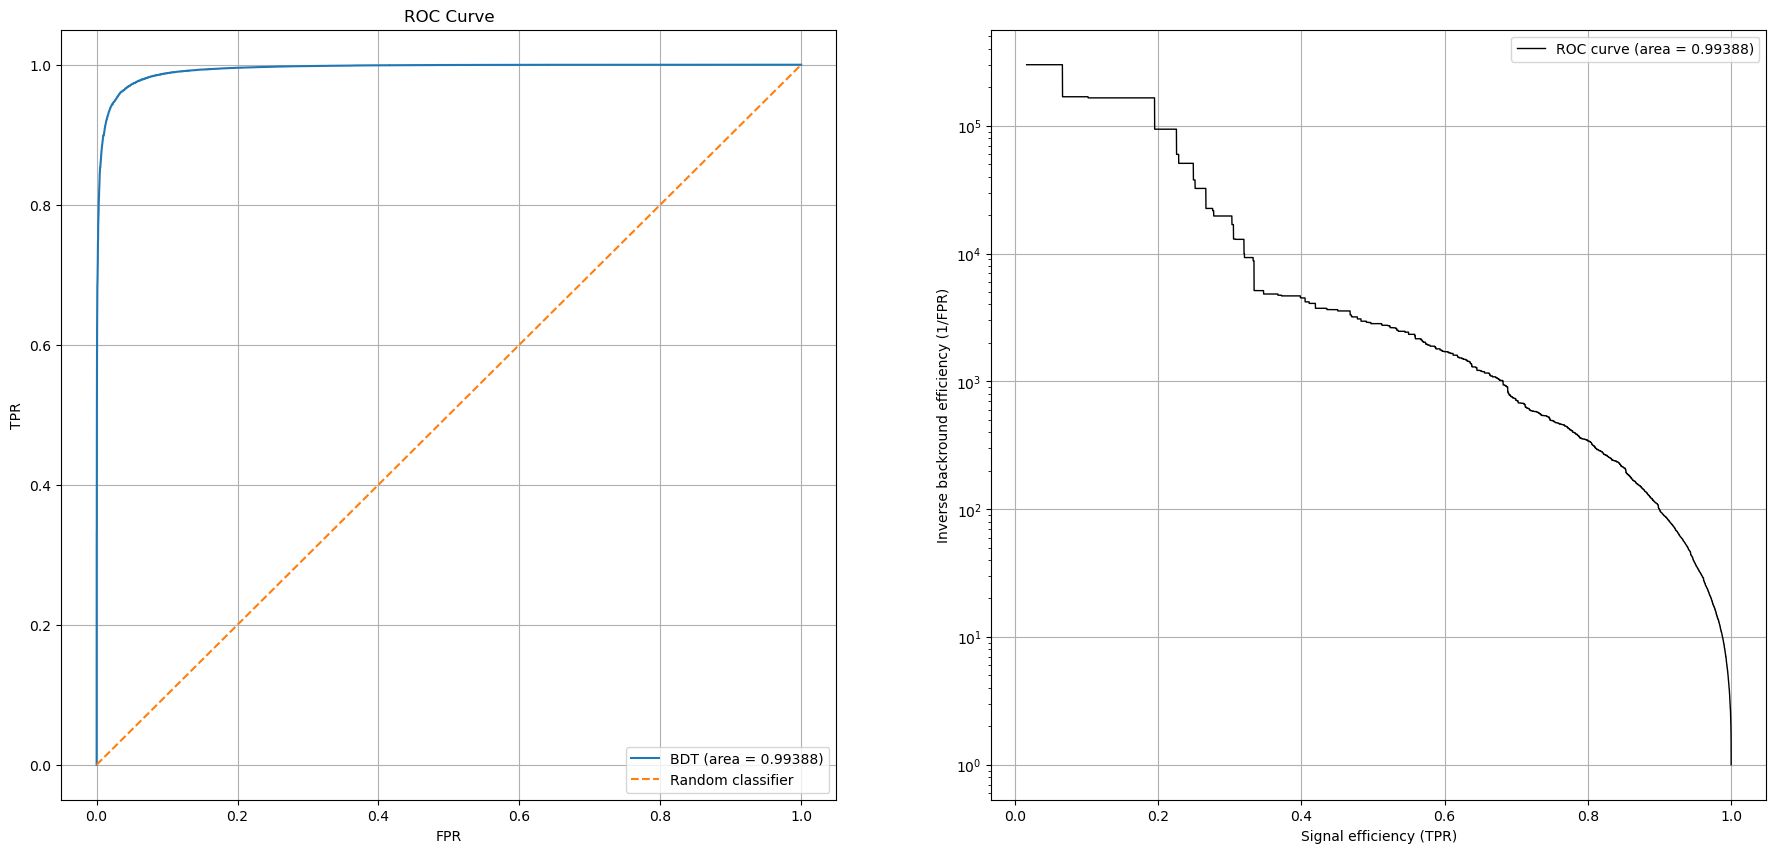

Pytorch Time: 57.61362920602163 min


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

start = time.time()

learning_rate = 0.0005
batch_size = 512
dropout = 0
neuron1 = 256
neuron2 = 1024
neuron3 = 512
neuron4 = 128
neuron5 = 32

# features = df[training_vars].values
# labels = df['label'].values
# weights = df['weight'].values

# # Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
#     features, labels, weights, test_size=0.2, random_state=42)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split the dataset into training and validation sets
df['eventID_mod'] = df['event_id'] % 10

train_loc = df['eventID_mod'] < 7 # 70%
test_loc = df['eventID_mod'] >= 7 # 30%

features, labels, weights = df[training_vars].values, df['label'].values, df['weight'].values

X_train, X_val, y_train, y_val, weights_train, weights_val = \
      features[train_loc], features[test_loc], labels[train_loc], labels[test_loc], weights[train_loc], weights[test_loc] 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
weights_train_tensor = torch.tensor(weights_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# Define the Dataset
class SignalBackgroundDataset(Dataset):
    def __init__(self, features, labels, weights):
        self.features = features
        self.labels = labels
        self.weights = weights

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.weights[idx]

# Define the DNN model with dropout
class DNN(nn.Module):
    def __init__(self, input_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, neuron1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(neuron1, neuron2)
        self.fc3 = nn.Linear(neuron2, neuron3)
        self.fc4 = nn.Linear(neuron3, neuron4)
        self.fc5 = nn.Linear(neuron4, neuron5)
        self.fc6 = nn.Linear(neuron5, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc6(x))
        return x

model = DNN(X_train_tensor.shape[1]).to(device)
criterion = nn.BCELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader for training data
train_dataset = SignalBackgroundDataset(X_train_tensor, y_train_tensor, weights_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SignalBackgroundDataset(X_val_tensor, y_val_tensor, torch.tensor(weights_val, dtype=torch.float32).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50
patience = 6  # How many epochs to wait after last time validation loss improved.
best_val_loss = np.inf  # Initialize best validation loss to infinity
epochs_no_improve = 0  # Counter for epochs with no improvement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions, total_predictions = 0, 0

    for inputs, targets, batch_weights in train_loader:
        inputs, targets, batch_weights = inputs.to(device), targets.to(device), batch_weights.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss = (loss * batch_weights).mean()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # binary classification for accuracy calculation
        preds = outputs.squeeze().round()
        correct_predictions += (preds == targets).sum().item()
        total_predictions += targets.size(0)

    train_accuracy = correct_predictions / total_predictions
    avg_training_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_predictions, total_predictions = 0, 0

    with torch.no_grad():
        for inputs, targets, batch_weights in val_loader:
            inputs, targets, batch_weights = inputs.to(device), targets.to(device), batch_weights.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss = (loss * batch_weights).mean()

            val_running_loss += loss.item()

            preds = outputs.squeeze().round()
            correct_predictions += (preds == targets).sum().item()
            total_predictions += targets.size(0)

    val_accuracy = correct_predictions / total_predictions
    avg_val_loss = val_running_loss / len(val_loader)

#     # Log metrics to W&B
#     wandb.log({
#         'epoch': epoch,
#         'training_loss': avg_training_loss,
#         'validation_loss': avg_val_loss,
#         'training_accuracy': train_accuracy,
#         'validation_accuracy': val_accuracy
#     })

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_training_loss:.4e}, Validation Loss: {avg_val_loss:.4e}, Training Accuracy: {train_accuracy:.4e}, Validation Accuracy: {val_accuracy:.4e}")

    # Check if the validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the model
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break  # Early stopping


# Evaluate on the validation set
model.eval()
val_predictions = []
with torch.no_grad():
    for inputs, targets, _ in DataLoader(SignalBackgroundDataset(X_val_tensor, y_val_tensor, torch.tensor(weights_val, dtype=torch.float32)), batch_size=batch_size, shuffle=False):
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze()
        val_predictions.extend(outputs.cpu().numpy())
val_predictions = np.array(val_predictions)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val, val_predictions, sample_weight=weights_val)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr, tpr, label='BDT (area = {:.5f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(tpr, 1/fpr, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse backround efficiency (1/FPR)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

print(f'Pytorch Time: {(time.time() - start)/60} min')

In [17]:
bdt_roc_data = {
    'tpr': tpr,
    'fpr': fpr
}
np.save('mlp_roc_data.npy', bdt_roc_data)


In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
# from sklearn.model_selection import RandomizedSearchCV
# from xgboost import XGBClassifier

# training_vars = ["f_core_lead",
#                 "f_core_subl",
#                 "f_subjet_subl",
#                 "f_subjets",
#                 # "f_isotracks",
#                 "R_max_lead",
#                 "R_max_subl",
#                 "R_isotrack",
#                 "R_tracks_subl",
#                 "m_core_lead",
#                 # "m_core_subl",
#                 "m_tracks_lead",
#                 # "m_tracks_subl",
#                 # "d0_leadtrack_lead",
#                 # "d0_leadtrack_subl",
#                 # "n_track",
#                 "n_tracks_lead"]


# # Scrambling
# # Calculate the modulo of each eventID with 5
# df['eventID_mod'] = df['event_id'] % 10

# df['weight'] = df['event_weight'] * df['pT_weight']

# log_vars = ["f_isotracks", "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl"]
# abs_log_var = ["d0_leadtrack_lead", "d0_leadtrack_subl"]

# train_df = df[df['eventID_mod'] < 7] # 70%
# test_df = df[df['eventID_mod'] >= 7] # 30%

# train_df = train_df.drop(columns='eventID_mod')
# test_df = test_df.drop(columns='eventID_mod')

# # Training & Testing sets
# training_data, testing_data, training_labels, testing_labels, training_weights, testing_weights = \
# train_df[training_vars], test_df[training_vars], train_df['label'], test_df['label'], train_df['weight'], test_df['weight']

# # Change column names to integers if needed (for ML models that expect numerical feature names)
# feature_mapping = {feature: i for i, feature in enumerate(training_data.columns)}
# training_data.rename(columns=feature_mapping, inplace=True)
# testing_data.rename(columns=feature_mapping, inplace=True)

# # Define the classifier
# bdt = XGBClassifier(random_state=0, verbosity=1)

# # Define the parameter distribution
# param_dist = {
#     'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
#     'max_depth': [2, 3, 4, 5, 6]
# }

# # Define the search with RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=bdt, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, verbose=2, random_state=0, n_jobs=-1)

# # Perform the search
# random_search.fit(training_data, training_labels, sample_weight=training_weights)

# # Best estimator found by RandomizedSearchCV
# best_estimator = random_search.best_estimator_

# # Predictions and final evaluation on the testing set
# predictions = best_estimator.predict(testing_data)
# accuracy = accuracy_score(testing_labels, predictions, sample_weight=testing_weights)

# # Output the results
# print("Best parameters found: ", random_search.best_params_)
# print("Testing accuracy: ", accuracy)

# # Feature Importance
# importance = best_estimator.feature_importances_
# # Re-map the feature importance scores to the original feature names
# feature_importances = {training_vars[i]: score for i, score in enumerate(importance)}

# # Predict probabilities for the testing data
# probs = best_estimator.predict_proba(testing_data)
# probs = probs[:, 1]

# fpr_w, tpr_w, thresholds_w = roc_curve(testing_labels, probs, sample_weight=testing_weights)
# auc_w = roc_auc_score(testing_labels, probs, sample_weight=testing_weights)
    
# # Plot feature importance
# plt.figure(figsize=(10, 8))
# plt.barh(range(len(feature_importances)), list(feature_importances.values()), align='center')
# plt.yticks(range(len(feature_importances)), list(feature_importances.keys()))
# plt.xlabel('Feature Importance Score')
# plt.title('Feature Importances')
# plt.show()

In [7]:
path_npy = "/global/u2/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/npy/"

filename = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights_good_run1.npy"
data = np.load(path_npy+filename,allow_pickle=True).item()

filename_s = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights.npy"
data_n = np.load(path_npy+filename_s,allow_pickle=True).item()

y_true = data['y'][:, 1]  # Select the true labels for the positive class
y_scores = data['pred'][:, 1]  # Select the predicted probabilities for the positive class
fpr_gnn, tpr_gnn, thresholds_gnn = roc_curve(y_true, y_scores)
auc_gnn = roc_auc_score(y_true, y_scores)

y_true_n = data_n['y'][:, 1]  # Select the true labels for the positive class
y_scores_n = data_n['pred'][:, 1]  # Select the predicted probabilities for the positive class
fpr_gnn_s, tpr_gnn_s, thresholds_gnn_s = roc_curve(y_true_n, y_scores_n)
auc_gnn_s = roc_auc_score(y_true_n, y_scores_n)

#load mlp_roc_data.npy
bdt_roc_data = np.load('mlp_roc_data.npy', allow_pickle=True).item()
fpr_mlp, tpr_mlp = bdt_roc_data['fpr'], bdt_roc_data['tpr']
auc_mlp = auc(fpr_mlp, tpr_mlp)

/tmp/ipykernel_858974/564074567.py:42: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_mlp, 1/fpr_mlp, color='green', lw=3, label='MLP', alpha=0.5)
/tmp/ipykernel_858974/564074567.py:43: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_gnn, 1/fpr_gnn, color='lightcoral', lw=3, label='Omni* fine-tuned', alpha=0.5)
/tmp/ipykernel_858974/564074567.py:44: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_gnn_s, 1/fpr_gnn_s, color='brown', lw=3, label='Omni scratch', alpha=0.5)


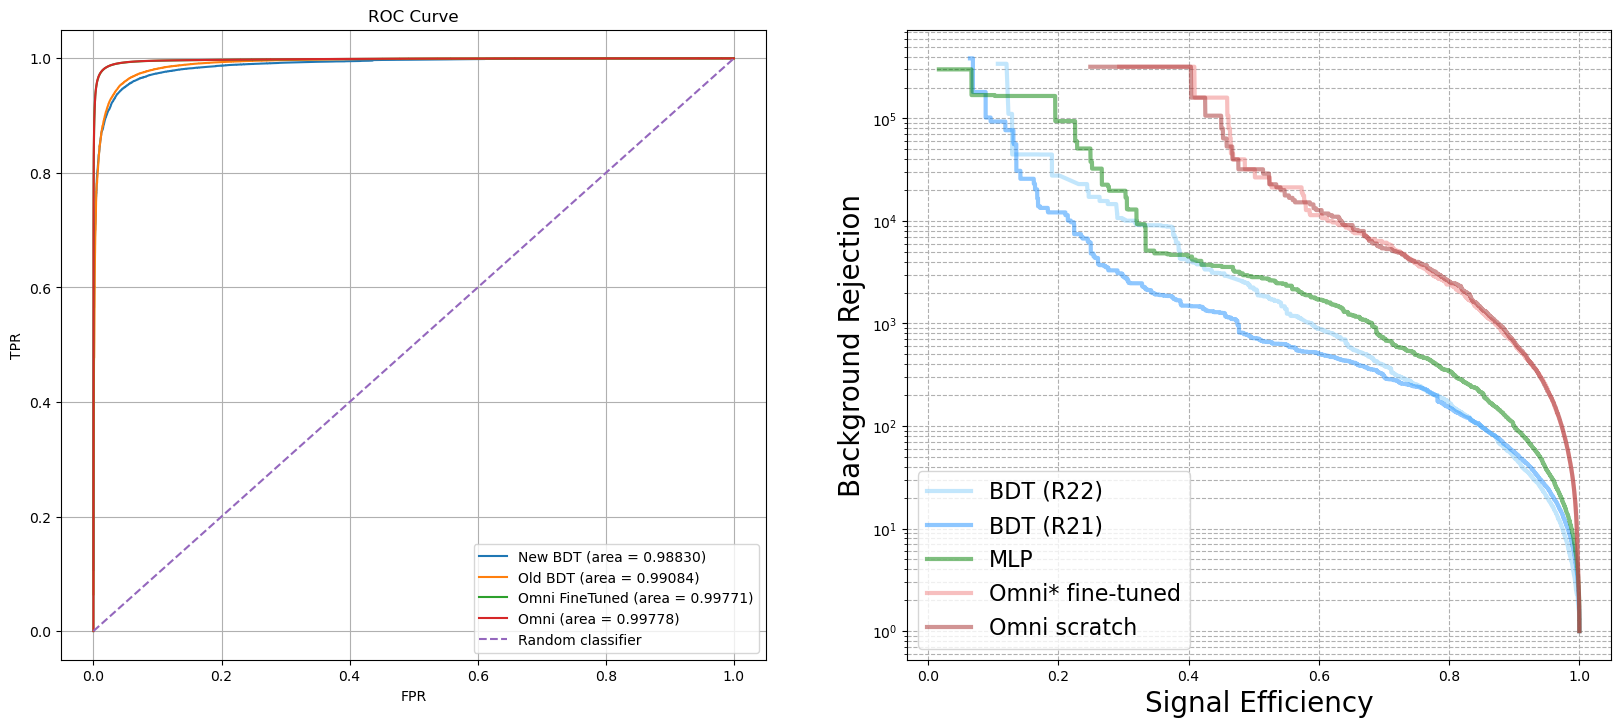

In [8]:
# Predict probabilities for the testing data
# probs = bdt.predict_proba(testing_data)
# probs = probs[:, 1]

# fpr_w, tpr_w, thresholds_w = roc_curve(testing_labels, probs, sample_weight=testing_weights)
# auc_w = roc_auc_score(testing_labels, probs, sample_weight=testing_weights)

old_bdt_score = test_df['bdt_score']
fpr_old, tpr_old, _ = roc_curve(testing_labels, old_bdt_score, sample_weight=testing_weights)
roc_auc_old = auc(fpr_old, tpr_old)

new_bdt_score = test_df['bdt_score_new']
fpr_w, tpr_w, _ = roc_curve(testing_labels, new_bdt_score, sample_weight=testing_weights)
auc_w = auc(fpr_w, tpr_w)



non_zero_indices = np.nonzero(fpr_w)
tpr_w = tpr_w[non_zero_indices]
fpr_w = fpr_w[non_zero_indices]

non_zero_indices_old = np.nonzero(fpr_old)
tpr_old = tpr_old[non_zero_indices_old]
fpr_old = fpr_old[non_zero_indices_old]

plt.figure(figsize=(20, 18))
plt.subplot(221)
plt.plot(fpr_w, tpr_w, label='New BDT (area = {:.5f})'.format(auc_w))
plt.plot(fpr_old, tpr_old, label='Old BDT (area = {:.5f})'.format(roc_auc_old))
plt.plot(fpr_gnn, tpr_gnn, label='Omni FineTuned (area = {:.5f})'.format(auc_gnn))
plt.plot(fpr_gnn_s, tpr_gnn_s, label='Omni (area = {:.5f})'.format(auc_gnn_s))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.plot(tpr_w, 1/fpr_w, color='lightskyblue', lw=3, label='BDT (R22)', alpha=0.5)
plt.plot(tpr_old, 1/fpr_old, color='dodgerblue', lw=3, label='BDT (R21)', alpha=0.5)
plt.plot(tpr_mlp, 1/fpr_mlp, color='green', lw=3, label='MLP', alpha=0.5)
plt.plot(tpr_gnn, 1/fpr_gnn, color='lightcoral', lw=3, label='Omni* fine-tuned', alpha=0.5)
plt.plot(tpr_gnn_s, 1/fpr_gnn_s, color='brown', lw=3, label='Omni scratch', alpha=0.5)
# plt.axhline(y=1e4, color='purple', linestyle='--', label='Background Rejection=10^4')
plt.xlabel('Signal Efficiency', fontsize=20)
plt.ylabel('Background Rejection', fontsize=20)
plt.yscale('log')
plt.legend(prop={'size': 16})
plt.grid(True, which="both", ls="--")

# plt.subplot(223)
# plt.hist(probs[testing_labels==1], bins=60, label='signal', histtype='step')
# plt.hist(probs[testing_labels==0], bins=60, label='background', histtype='step')
# plt.xlabel('BDT Score')
# plt.yscale('log')
# plt.legend()
# plt.grid(True)
# plt.show()

In [20]:
combined_bkg['inc_new_bdt'] = np.nan
combined_bkg.loc[(combined_bkg['event_id'] % 10) >= 7, 'inc_new_bdt'] = probs[testing_labels==0]
combined_bkg['inc_new_bdt'] = combined_bkg['inc_new_bdt'].fillna(0)
combined_bkg.to_csv('/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/inc_bdt_bkg.csv', index=False)

In [13]:
len(y_scores)

1446757

In [14]:
combined_bkg['omni_score'] = y_scores[y_true==0]
combined_bkg['omni_score'] = combined_bkg['omni_score'].fillna(0)
combined_bkg.to_csv('/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/bkg_with_omni.csv', index=False)

ValueError: Length of values (318775) does not match length of index (1147050)

In [27]:
combined_bkg.columns

Index(['event_id', 'ditau_pt', 'IsTruthHadronic', 'f_core_lead', 'f_core_subl',
       'f_subjet_subl', 'f_subjets', 'f_isotracks', 'R_max_lead', 'R_max_subl',
       'R_isotrack', 'R_tracks_subl', 'm_core_lead', 'm_core_subl',
       'm_tracks_lead', 'm_tracks_subl', 'd0_leadtrack_lead',
       'd0_leadtrack_subl', 'n_track', 'n_tracks_lead', 'n_tracks_subl',
       'n_subjets', 'event_weight', 'bdt_score', 'bdt_score_new', 'average_mu',
       'eta', 'lead_subjet_pt', 'sublead_subjet_pt', 'pT_weight', 'label',
       'weight', 'inc_new_bdt'],
      dtype='object')

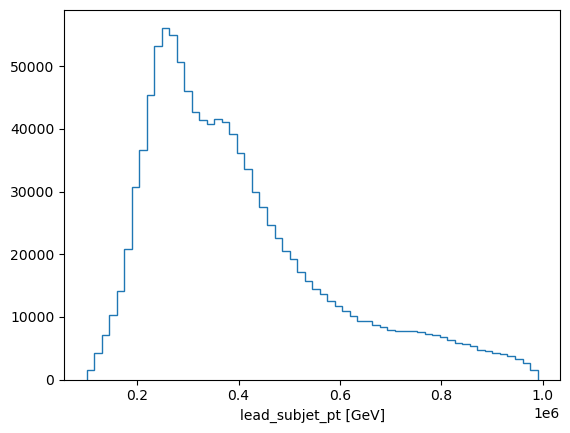

In [25]:
#plot sublead_subjet_pt
plt.hist(combined_bkg['lead_subjet_pt'], bins=60, histtype='step', label='background')
#xaix title 
plt.xlabel('lead_subjet_pt [GeV]')
plt.show()

In [13]:
combined_signal['inc_new_bdt'] = np.nan
combined_signal.loc[(combined_signal['event_id'] % 10) >= 7, 'inc_new_bdt'] = probs[testing_labels==1]
combined_signal['inc_new_bdt'] = combined_signal['inc_new_bdt'].fillna(0)
combined_signal.to_csv('/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/inc_bdt_vhtautau.csv', index=False)

In [9]:
len(combined_signal[(combined_signal['event_id'] % 10) >= 7])

87871

In [10]:
len(probs[testing_labels==1])

87871

In [12]:
bdt.save_model('bdt_results/xgb_model.json')

In [14]:
bdt.save_model('bdt_results/xgb_model.model')

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [17:15:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
